In [22]:
import pandas as pd

url = "https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Default.xlsx"

df = pd.read_excel(url)

# Encode 'default' column
df['default'] = df['default'].map({'Yes': 1, 'No': 0})

# Encode 'student' column
df['student'] = df['student'].map({'Yes': 1, 'No': 0})

# Display the first few rows
print(df.head())

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


   Unnamed: 0  default  student      balance        income
0           1        0        0   729.526495  44361.625074
1           2        0        1   817.180407  12106.134700
2           3        0        0  1073.549164  31767.138947
3           4        0        0   529.250605  35704.493935
4           5        0        0   785.655883  38463.495879


In [23]:
# Calculate the percentage of defaulters
num_defaulters = df['default'].sum()
total_customers = len(df)
percentage_defaulters = (num_defaulters/total_customers) * 100

print(f"Number of defaulters: {num_defaulters}")
print(f"Total customers: {total_customers}")
print(f"Percentage of defaulters: {percentage_defaulters:.2f}%")

Number of defaulters: 333
Total customers: 10000
Percentage of defaulters: 3.33%


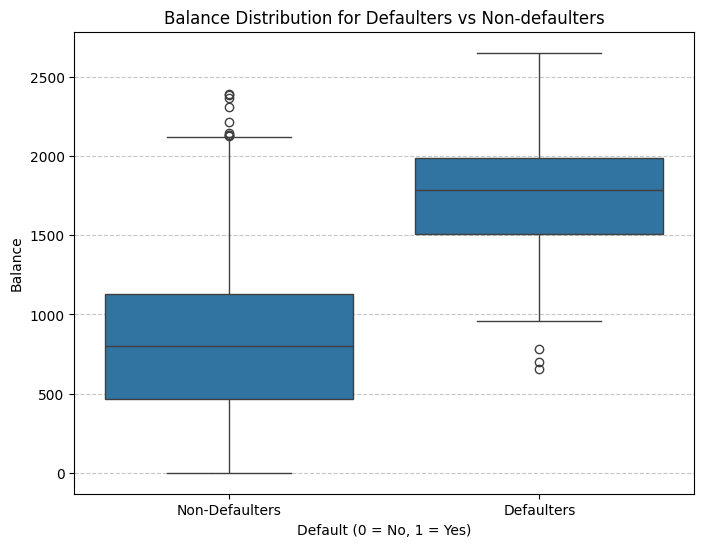

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='default', y='balance', data=df)
plt.title('Balance Distribution for Defaulters vs Non-defaulters')
plt.xlabel('Default (0 = No, 1 = Yes)')
plt.ylabel('Balance')
plt.xticks([0, 1], ['Non-Defaulters', 'Defaulters'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

From the boxplot, we can see the distribution of balance for both groups. It appears that defaulters tend to carry higher average balances compared to non-defaulters. The median balance for defaulters is visibly higher, suggesting that a higher balance is indeed associated with a higher likelihood of default.

The reason a "dumb" model that predicts 'No Default' for everyone would have high accuracy is due to the imbalance in the dataset.

Since the percentage of defaulters is very low (only 3%), the majority class is 'No Default'. If a model predicts 'No Default' for every single case, it will be correct for all the instances where there is no default. This means its accuracy score will be very high, close to the percentage of non-defaulters.

However, such a model would be practically useless because it would fail to identify any actual defaulters.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = df[['student', 'balance', 'income']]
y = df['default']

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Fit the model
log_model = LogisticRegression(solver='liblinear', random_state=1)

# Fit the model to the training data
log_model.fit(X_train, y_train)


LogisticRegression(random_state=1, solver='liblinear')

In [26]:
# Get the coefficients and intercept from the model
coefficients = pd.Series(log_model.coef_[0], index=X.columns)
intercept = log_model.intercept_[0]

print("Model Coefficients:")
print(coefficients)
print(f"\nModel Intercept: {intercept:.4f}")

Model Coefficients:
student   -0.000003
balance    0.000408
income    -0.000123
dtype: float64

Model Intercept: -0.0000


The coefficient for balance is 0.000408. This positive value means that as a customer's balance increases, their risk of defaulting also increases.
The coefficient for income is -0.000123. This negative value indicates that as a customer's income increases, their risk of defaulting decreases.
Comparing the absolute magnitudes, balance (0.000408) has a larger impact on the odds of default than income (0.000123). Therefore, an increase in Balance creates more risk of default.

The coefficient for student is -0.000003. This small negative sign suggests that being a student slightly decreases the risk of default. However, the magnitude of this coefficient is very small, implying that student status has a negligible effect on the default risk here.


In [27]:
from sklearn.linear_model import LogisticRegression

lasso_log_model = LogisticRegression(penalty='l1', solver='liblinear', C=0.01, random_state=1)

# Fit the model
lasso_log_model.fit(X_train, y_train)

# Get the coefficients
lasso_coefficients = pd.Series(lasso_log_model.coef_[0], index=X.columns)

print("Lasso Logistic Model Coefficients:")
print(lasso_coefficients)

# Check if any coefficients dropped to zero
zero_coefs = lasso_coefficients[lasso_coefficients == 0.0]

if zero_coefs.empty:
    print("\nNo coefficients dropped to zero.")
else:
    print("\nThese coefficients dropped to zero:")
    print(zero_coefs)

Lasso Logistic Model Coefficients:
student   -1.069432
balance    0.001779
income    -0.000099
dtype: float64

No coefficients dropped to zero.


None of the coefficients dropped to zero. This indicates that with C=0.01 and for this specific dataset and features, the L1 regularization was not strong enough to completely eliminate any of the features. All three features (student, balance, income) are still considered by the model to have some predictive power for default status.

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Scale features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit KNN with k=9
knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=9)

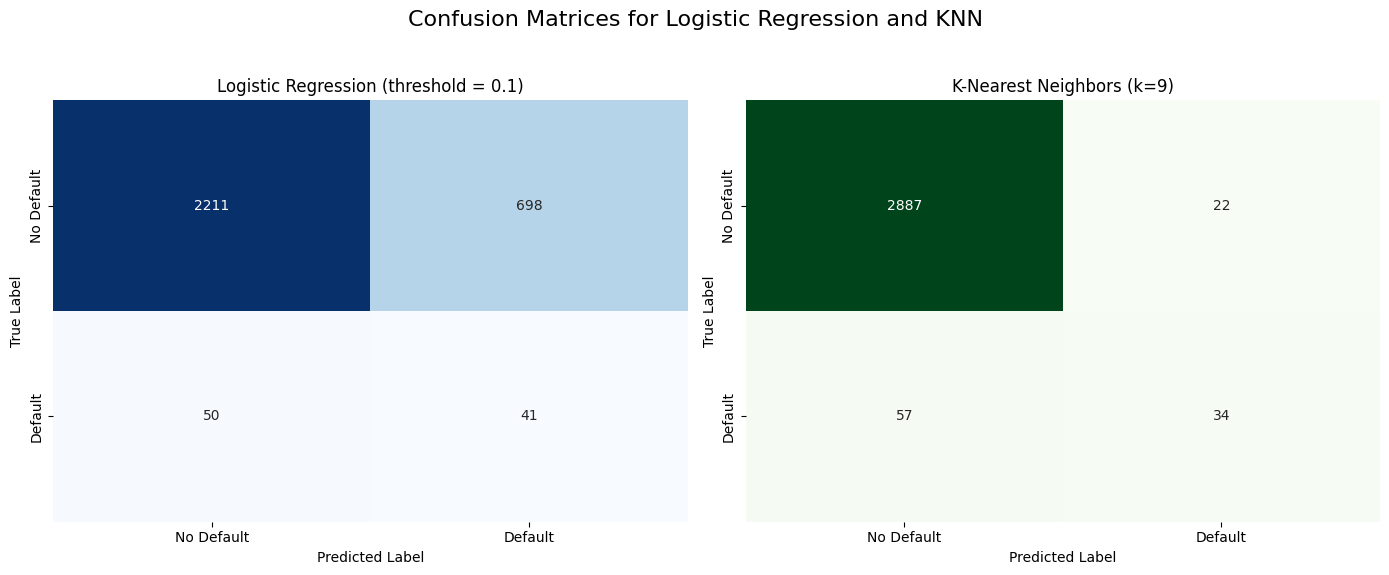


Model Performance Comparison (Focus on Default=1 class):


,Model,Accuracy,Recall,Precision,F1-Score,ROC-AUC Score
0,Logistic Regression,0.750667,0.450549,0.055480,0.098795,0.638647
1,KNN,0.973667,0.373626,0.607143,0.462585,0.862337


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
import pandas as pd

# Logistic Regression probs
y_prob_log_reg = log_model.predict_proba(X_test)[:, 1]
threshold = 0.1
y_pred_log_reg_custom = (y_prob_log_reg >= threshold).astype(int)

# KNN predictions
y_pred_knn = knn_model.predict(X_test_scaled)
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Confusion Matrices for Logistic Regression and KNN', fontsize=16)

# Confusion matrix for Logistic Regression
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg_custom)
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Logistic Regression (threshold = 0.1)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(['No Default', 'Default'])
axes[0].set_yticklabels(['No Default', 'Default'])

# Confusion matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('K-Nearest Neighbors (k=9)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(['No Default', 'Default'])
axes[1].set_yticklabels(['No Default', 'Default'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Compare metrics
metrics_data = {
    'Model': ['Logistic Regression', 'KNN'],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F1-Score': [],
    'ROC-AUC Score': []
}

# Logistic Regression metrics
report_log_reg = classification_report(y_test, y_pred_log_reg_custom, output_dict=True)
roc_auc_log_reg = roc_auc_score(y_test, y_prob_log_reg)

metrics_data['Accuracy'].append(accuracy_score(y_test, y_pred_log_reg_custom))
metrics_data['Recall'].append(report_log_reg['1']['recall'])
metrics_data['Precision'].append(report_log_reg['1']['precision'])
metrics_data['F1-Score'].append(report_log_reg['1']['f1-score'])
metrics_data['ROC-AUC Score'].append(roc_auc_log_reg)

# KNN metrics
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)

metrics_data['Accuracy'].append(accuracy_score(y_test, y_pred_knn))
metrics_data['Recall'].append(report_knn['1']['recall'])
metrics_data['Precision'].append(report_knn['1']['precision'])
metrics_data['F1-Score'].append(report_knn['1']['f1-score'])
metrics_data['ROC-AUC Score'].append(roc_auc_knn)

metrics_df = pd.DataFrame(metrics_data)
print("\nModel Performance Comparison (Focus on Default=1 class):")
display(metrics_df)


**Recall:** Which model is safer (misses fewer defaulters)?

* Logistic Regression (Recall = 0.4505)

Recall measures how many actual defaulters the model successfully identifies.
Logistic Regression catches about 45% of the defaulters, while KNN catches about 37%.

**Precision:** Which model is more efficient (fewer false alarms)?

* KNN (Precision = 0.6071)

Precision measures how many predicted defaulters truly defaulted.
KNN is correct 60% of the time.
Logistic Regression is only correct 5.5% of the time.

Here, KNN is far more efficient, meaning it falsely accuses fewer good customers.

**F1-Score:** Which model provides the best balance between Recall and Precision?

* KNN (F1 = 0.4626)

The F1-Score combines both Precision and Recall.
KNN’s F1-Score is almost 5× higher than Logistic Regression.

It seems like KNN provides the best overall balance between catching defaulters and avoiding false accusations.

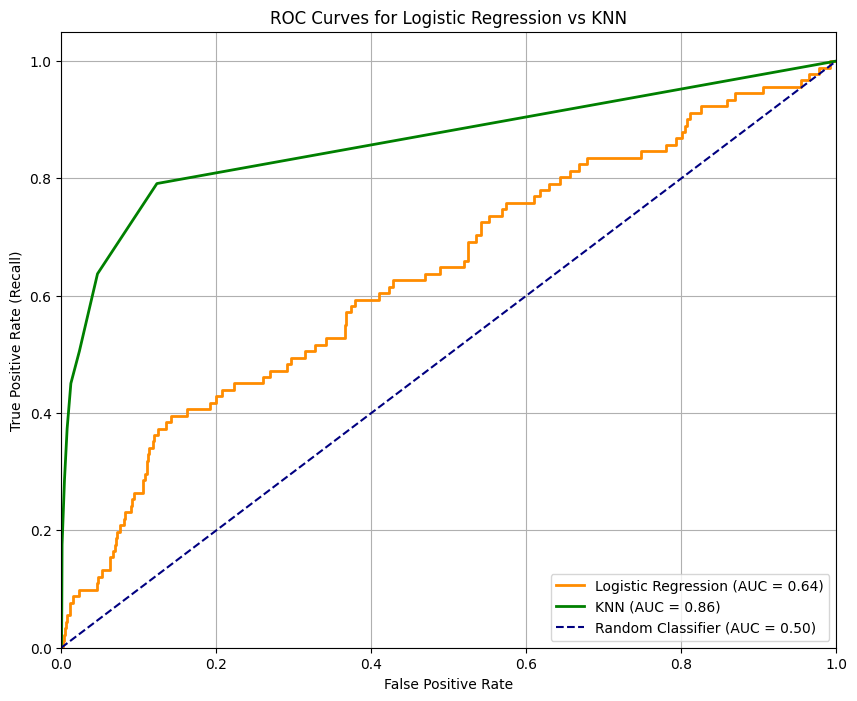

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# ROC for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log_reg)
auc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, lw=2, label=f'Logistic Regression (AUC = {auc_log:.2f})', color='darkorange')

# ROC for KNN (using scaled test data)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, lw=2, label=f'KNN (AUC = {auc_knn:.2f})', color='green')

# Random baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Random Classifier (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves for Logistic Regression vs KNN')
plt.legend(loc="lower right")
plt.grid(True)

plt.show()


From the  plot, we observe that the KNN model's ROC curve is significantly closer to the top-left corner compared to the Logistic Regression model's curve. This indicates that KNN has a much better overall performance in distinguishing between the positive (default) and negative (non-default) classes across different probability thresholds.

**Scenario A:** The bank is conservative and fears losing principal (Needs high Recall)

- **Choose:** Logistic Regression (Recall = 0.45)

Logistic Regression catches 45.05% of defaulters, which is higher than KNN’s 37.36%.

**Scenario B:** The bank wants to grow and avoid rejecting good customers (Needs high Precision)

- **Choose:** KNN (Precision = 0.607)

KNN is correct 60.7% of the time when it predicts a default, while Logistic Regression is correct only 5.55% of the time.



#
Considering both explainability (Part 2) and predictive performance (Part 3), I would choose KNN as the final model to deploy.

While Logistic Regression is easier to interpret: its coefficients clearly show how balance, income, and student status affect default risk, the model performs much worse in detecting defaults. In Part 3, KNN achieved much higher Precision, F1-Score, and ROC-AUC, indicating that it is far better at correctly identifying risky customers.